# Detectando e Interpretando Sinais Periódicos em Séries Temporais Paleobiológicas

**Análise Espectral de Diversidade de Gêneros Marinhos**

**Disciplina:** CCM0228 - Computação IV (2025.1)  
**Autores:**
- Helena Baptista Reis (NUSP: 14577622)
- Luca Marinho Nasser Valadares Paiva (NUSP: 13691375)

## Resumo do Projeto

Este notebook implementa uma análise espectral para detectar e interpretar sinais periódicos em séries temporais paleobiológicas. Utilizamos dados de diversidade de gêneros marinhos ao longo do tempo geológico para investigar padrões cíclicos que podem estar relacionados a processos geológicos, climáticos ou astronômicos.

## Metodologia

1. **Pré-processamento:** Carregamento dos dados e Remoção de tendências de longo prazo
2. **Análise Espectral:** Aplicação de Transformada de Fourier (FFT) e Identificação dos picos relevantes
3. **Construção de Modelos Nulos:** Simulações de Monte Carlo
4. **Validação Estatística:** Teste de significância dos picos relevantes no espectro real e nos simulados

## Organização do Código
O código está organizado em blocos funcionais modulares para máxima reutilização e clareza:

### Configuração e Dependências

In [ ]:
# ============================
# CONFIGURAÇÃO E DEPENDÊNCIAS
# ============================

# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuração de caminhos
DATA_ROOT = Path("data")
GENERA_DATA_PATH = DATA_ROOT / "raw" / "genera_data.csv"
RESULTS_PATH = DATA_ROOT / "processed"

# Configuração de plotagem
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 10
})

# Configuração de seeds para reprodutibilidade (Answer to life, the universe, and everything)
# np.random.seed(42)

### Módulo de Processamento de Dados
- `carregar_dados()` - Carrega CSV e normaliza diversidade para milhares
- `ajustar_polinomio()` - Ajusta polinômio (de grau 3) para remoção de tendência
- `calcular_residuos()` - Remove tendência (subtrai polinômio de ajustado) e calcula série centrada em zero (resíduos)

In [309]:
# ============================
# MÓDULO: PROCESSAMENTO DE DADOS
# ============================

def carregar_dados(caminho_arquivo):
    """
    Carrega um arquivo CSV contendo dados de diversidade ao longo do tempo.

    Args:
        caminho_arquivo: Caminho para o arquivo CSV contendo os dados
    
    Returns: DataFrame, Tempo, Diversidade normalizada
    """
    df = pd.read_csv(caminho_arquivo)
    x = df["TimeBin"].values
    y = (df["Diversity"] / 1000).values  # Diversidade convertida para milhares de gêneros
    
    return df, x, y


def ajustar_polinomio(y, grau=3):
    """
    Ajusta polinômio para remoção de tendência.
    
    Args:
        y: Série temporal
        grau: Grau do polinômio (default=3)
    
    Returns: Função polinomial ajustada
    """
    x_indices = np.arange(len(y)) # Vetor de índices inteiros para o ajuste polinomial
    
    coeficientes = np.polyfit(x_indices, y, grau)
    polinomio = np.poly1d(coeficientes)
    
    return polinomio


def calcular_residuos(y, polinomio):
    """
    Remove tendência calculando resíduos centrados em zero.

    Args:
        y: Série temporal
        polynomial: Função polinomial ajustada
    
    Returns: Série de resíduos (dados - tendência)
    """
    x_indices = np.arange(len(y))
    
    tendencia = polinomio(x_indices) # Avalia o polinômio nos índices
    residuos = y - tendencia
    
    return residuos

### Módulo de Análise Espectral
- `calcular_espectro_potencia()` - Aplica FFT com padding opcional (para melhora da resolução do espectro)
- `identificar_picos_espectrais()` - Detecta picos com threshold adaptativo

In [310]:
# ============================
# MÓDULO: ANÁLISE ESPECTRAL
# ============================

def calcular_espectro_potencia(serie, pad=1):
    """
    Calcula espectro de potência via FFT.
    
    Args:
        series: Série temporal
        pad: Fator de zero-padding (default=1)
    
    Returns: Frequências positivas, Potências normalizadas
    """
    # Preenche a série com zeros até o tamanho desejado
    N = len(serie)
    N_pad = pad * N
    serie_padded = np.pad(serie, (0, N_pad - N), 'constant') 

    # Calcula FFT e potências
    freqs = fftfreq(len(serie_padded)) 
    fft_vals = fft(serie_padded)
    potencia = (np.abs(fft_vals) / len(serie_padded))**2 
    
    # Filtra frequências positivas e relevantes (período > 20 Myr, 0 < f < 0.05)
    mask = (freqs > 0) & (freqs < 0.05)
    freqs_positivas = freqs[mask]
    potencias_positivas = potencia[mask]
    
    return freqs_positivas, potencias_positivas


def identificar_picos_espectrais(freqs, pots, threshold=0.1, distancia_minima=0.02):
    """
    Identifica picos estatisticamente relevantes.

    Args:
        freqs: Vetor de frequências do espectro
        pots: Vetor de potências do espectro
        threshold: Fração da potência máxima para detectar pico (default=0.1)
        distancia_minima: Distância mínima entre picos, em fração do intervalo total de frequências (default=0.02)

    Returns: Índices dos picos, Alturas dos picos
    """
    threshold *= np.max(pots) # Valor absoluto do threshold baseado na potência máxima

    # Calcula a distância mínima entre picos em termos de índices
    range_freqs = freqs[-1] - freqs[0]
    distancia_minima *= range_freqs 
    indices_distancia_minima = int(distancia_minima / (freqs[1] - freqs[0]))

    # Encontra picos
    picos, propriedades = find_peaks(pots, height=threshold, distance=max(indices_distancia_minima, 1))
    alturas = propriedades['peak_heights']

    return picos, alturas

### Módulo de Modelos Nulos
- `modelo_r()` - Random Walk: Realiza simulações de Monte Carlo embaralhando incrementos
- `modelo_w()` - Windowed Bootstrap: Realiza simulações de Monte Carlo embaralhando blocos
- `_embaralhar_incrementos()` - Função auxiliar para implementação do Modelo R
- `_embaralhar_blocos()` - Função auxiliar para implementação do Modelo W
- `_simular_e_calcular_espectros()` - Função auxiliar para cálculo do espectro médio dos modelos nulos

In [311]:
# ============================
# MÓDULO: MODELOS NULOS (MONTE CARLO)
# ============================

def modelo_r(y, grau=3, pots_ref=None, n_simulacoes=30000, pad=1):
    """
    Modelo R (Random Walk): Embaralhamento de incrementos da série original.

    Args:
        y: Série temporal original (array 1D)
        grau: Grau do polinômio para remoção de tendência (default=3)
        n_simulacoes: Número de simulações Monte Carlo (default=30000)
        pad: Fator de padding para FFT (default=1)

    Returns:
        freqs: Vetor de frequências
        espectro_medio: Média dos espectros simulados
        espectros_individuais: Array (n_simulacoes, n_freqs) com todos os espectros simulados
    """
    series_simuladas = _embaralhar_incrementos(y, n_simulacoes)
    freqs, espectro_medio, espectros_individuais = _simular_e_calcular_espectros(
        series_simuladas, detrend=True, grau=grau, pad=pad, retornar_todos=True, normalizar=True, pots_ref=pots_ref
    )
    return freqs, espectro_medio, espectros_individuais



def modelo_w(residuos, n_blocos=20, pots_ref=None, n_simulacoes=30000, pad=1):
    """
    Modelo W (Windowed Bootstrap): Embaralhamento de blocos.

    Args:
        residuos: Série de resíduos original (já sem tendência)
        n_blocos: Número de blocos em que a série será dividida (default=20)
        n_simulacoes: Número de simulações Monte Carlo (default=30000)
        pad: Fator de padding para FFT (default=1)

    Returns:
        freqs: Vetor de frequências
        espectro_medio: Média dos espectros simulados
        espectros_individuais: Array (n_simulacoes, n_freqs) com todos os espectros simulados
    """
    series_simuladas = _embaralhar_blocos(residuos, n_simulacoes, n_blocos)
    freqs, espectro_medio, espectros_individuais = _simular_e_calcular_espectros(
        series_simuladas, detrend=False, pad=pad, retornar_todos=True, normalizar=True, pots_ref=pots_ref
    )
    return freqs, espectro_medio, espectros_individuais


def _embaralhar_incrementos(y, n_simulacoes):
    """
    Gera séries simuladas embaralhando incrementos (modelo R).

    Args:
        y: Série temporal original (array 1D)
        n_simulacoes: Número de séries simuladas a serem geradas

    Returns:
        Lista de séries simuladas
    """
    incrementos = np.diff(y)
    
    series_simuladas = []
    for _ in range(n_simulacoes):
        inc_embaralhados = np.random.permutation(incrementos)
        serie_sim = np.zeros(len(y))
        serie_sim[0] = y[0]
        for j in range(1, len(y)):
            serie_sim[j] = serie_sim[j-1] + inc_embaralhados[j-1]
        series_simuladas.append(serie_sim)
    return series_simuladas


def _embaralhar_blocos(serie, n_simulacoes, n_blocos=20):
    """
    Divide a série de resíduos em blocos contíguos e embaralha esses blocos para gerar séries simuladas.

    Args:
        serie: Série de resíduos original (array 1D)
        n_blocos: Número de blocos em que a série será dividida (default=20)
        n_simulacoes: Número de séries simuladas a serem geradas

    Returns:
        Lista de séries simuladas
    """
    n_pontos = len(serie)
    tamanho_bloco = int(np.ceil(n_pontos / n_blocos))
    blocos = [serie[j:min(j + tamanho_bloco, n_pontos)] for j in range(0, n_pontos, tamanho_bloco)]
    blocos = np.array(blocos, dtype=object)

    series_simuladas = []
    for _ in range(n_simulacoes):
        indices_embaralhados = np.random.permutation(len(blocos))
        blocos_embaralhados = blocos[indices_embaralhados]
        serie_simulada = np.concatenate(blocos_embaralhados)[:n_pontos]
        series_simuladas.append(serie_simulada)
    return series_simuladas


def _simular_e_calcular_espectros(
    series_simuladas, detrend=True, grau=3, pad=1, retornar_todos=False, normalizar=True, pots_ref=None
):
    """
    Calcula espectros de potência para uma lista de séries simuladas.

    Args:
        series_simuladas: Lista de séries simuladas (arrays 1D)
        detrend: Se True, remove tendência polinomial antes da FFT (default=True)
        grau: Grau do polinômio para detrending (default=3)
        pad: Fator de zero-padding para FFT (default=1)
        retornar_todos: Se True, retorna também todos os espectros individuais
        normalizar: Se True, normaliza cada espectro simulado para ter média igual ao espectro real
        pots_ref: Espectro real de referência (obrigatório se normalizar=True)

    Returns:
        freqs_comum: Vetor de frequências comum a todas as simulações
        espectro_medio: Espectro médio das simulações
        espectros_pots (opcional): Array (n_simulacoes, n_freqs) com todos os espectros simulados
    """
    espectros_pots = []
    freqs_comum = None
    for serie in series_simuladas:
        if detrend:
            polinomio = ajustar_polinomio(serie, grau=grau)
            residuos = calcular_residuos(serie, polinomio)
            dados_fft = residuos
        else:
            dados_fft = serie
        freqs, pots = calcular_espectro_potencia(dados_fft, pad=pad)

        if freqs_comum is None:
            freqs_comum = freqs
            # Salva média do espectro real para normalização
            if normalizar and pots_ref is not None:
                media_pots_ref = np.mean(pots_ref)
            elif normalizar:
                raise ValueError("Se normalizar=True, pots_ref deve ser fornecido.")

        # Normalização: iguala a média do espectro simulado à do espectro real
        if normalizar:
            pots = pots * (media_pots_ref / np.mean(pots))

        espectros_pots.append(pots)

    espectros_pots = np.array(espectros_pots)
    espectro_medio = np.mean(espectros_pots, axis=0)

    if retornar_todos:
        return freqs_comum, espectro_medio, espectros_pots
    else:
        return freqs_comum, espectro_medio

### Módulo de Testes de Significância
- `testar_significancia_pontual()` - Teste pontual: compara altura do pico real com simulações na mesma frequência
- `testar_significancia_global()` - Teste global: verifica se ocorre pico tão alto em qualquer frequência nas simulações
- `gerar_tabela_significancia()` - Gera tabela de p-valores dos testes de significância

In [312]:
# ============================
# MÓDULO: TESTES DE SIGNIFICÂNCIA
# ============================

def testar_significancia_pontual(pots_ref, pots_sim, freq_ind, altura_minima=None):
    """
    Teste pontual: calcula o p-valor de obter um pico tão alto quanto o real na frequência freq_ind.
    """
    if altura_minima is None:
        altura_minima = pots_ref[freq_ind]
    alturas_sim = pots_sim[:, freq_ind]
    p_valor = np.mean(alturas_sim >= altura_minima)
    return p_valor

def testar_significancia_global(pots_ref, pots_sim, freq_ind, fracao_minima_variancia=0.05):
    """
    Teste global: calcula o p-valor de obter um pico tão alto quanto o real em qualquer frequência independente.
    """
    # Obtém índices de frequências independentes igualmente espaçadas
    total_myr, min_period = 542, 5.5
    n_freqs_indep = int(total_myr / min_period)
    n_freqs = pots_ref.shape[0]
    indices = np.linspace(0, n_freqs-1, n_freqs_indep, dtype=int)

    # Critérios biológico e estatístico para a altura mínima do pico
    var_total = np.sum(pots_ref)
    altura_ref = pots_ref[freq_ind]
    altura_min = max(altura_ref, fracao_minima_variancia * var_total)

    # Para cada frequência independente, calcula a fração de simulações sem pico significativo
    P_NC = [1 - testar_significancia_pontual(pots_ref, pots_sim, idx, altura_minima=altura_min) for idx in indices]
    P_NC = np.array(P_NC)

    # P-valor global: probabilidade de não observar pico significativo em nenhuma das frequências independentes
    p_valor = 1 - np.prod(P_NC)

    return p_valor

def gerar_tabela_significancia(freqs_ref, pots_ref, individuais_r, individuais_w, periodos=None):
    """
    Calcula os p-valores pontuais e globais para os picos nos modelos R e W e retorna tabela formatada.
    """
    if periodos is None:
        periodos = [62, 140]
    index = []
    columns = ['R (na freq.)', 'W (na freq.)', 'R (em qualquer freq.)', 'W (em qualquer freq.)']
    data = []
    for periodo in periodos:
        idx = np.argmin(np.abs(freqs_ref - (1 / periodo)))
        # Testes modelo R
        pvalor_r_pontual = testar_significancia_pontual(pots_ref, individuais_r, idx)
        pvalor_r_global = testar_significancia_global(pots_ref, individuais_r, idx)
        # Testes modelo W
        pvalor_w_pontual = testar_significancia_pontual(pots_ref, individuais_w, idx)
        pvalor_w_global = testar_significancia_global(pots_ref, individuais_w, idx)
        index.append(f"{periodo} Myr")
        row = [pvalor_r_pontual, pvalor_w_pontual, pvalor_r_global, pvalor_w_global]
        data.append(row)
    df = pd.DataFrame(data, index=index, columns=columns)
    return df

### Módulo de Visualização
- `plotar_serie_temporal()` - Plot da série temporal, opcionalmente contendo polinômio ajustado e resíduos
- `plotar_espectro_potencia()` - Plot do espectro de potências, opcionalmente contendo modelos nulos
- `criar_dashboard_completo()` - Dashboard integrado multi-painel

In [313]:
# ============================
# MÓDULO: VISUALIZAÇÃO
# ============================

def plotar_serie_temporal(x, y, titulo, nome_arquivo, polinomio=None, residuos=None):
    """
    Plota séries temporais.
    
    Args:
        x, y: Dados temporais
        titulo: Título do gráfico
        nome_arquivo: Nome para salvar
        polinomio: Função polinomial (opcional)
        residuos: Série de resíduos (opcional)
        
    Returns: None
    """
    # Configurações padrão
    config = {
        'figsize': (8, 6),
        'xlim': (0, 542), 'xticks': np.arange(0, 542, 100),
        'ylim': (-1, 5.5), 'yticks': np.arange(0, 6),
        'cores': {'serie': 'black', 'tendencia': 'red', 'residuos': 'blue'},
        'estilos': {
            'serie': {'linewidth': 0.8, 'alpha': 0.8},
            'tendencia': {'linewidth': 1.2, 'linestyle': '-'},
            'residuos': {'linewidth': 0.8, 'alpha': 0.8}
        }
    }

    # Cria figura e plot principal
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.stairs(  y, 
                linewidth=config['estilos']['serie']['linewidth'], 
                color=config['cores']['serie'], 
                alpha=config['estilos']['serie']['alpha'],
                label="Série Temporal")
    
    # Adiciona tendência (se fornecida)
    if polinomio is not None:
        x_indices = np.arange(len(y))
        tendencia = polinomio(x_indices)
        ax.plot(x, tendencia, color=config['cores']['tendencia'], 
                linewidth=config['estilos']['tendencia']['linewidth'],
                linestyle=config['estilos']['tendencia']['linestyle'],
                label="Tendência")
    
    # Adiciona resíduos (se fornecidos)
    if residuos is not None:
        ax.plot(x, residuos, color=config['cores']['residuos'], 
                linewidth=config['estilos']['residuos']['linewidth'],
                alpha=config['estilos']['residuos']['alpha'], 
                label="Resíduos")
    
    # Configurações finais
    ax.set(xlim=config['xlim'], xticks=config['xticks'],
           ylim=config['ylim'], yticks=config['yticks'],
           xlabel="Idade (Myr)", ylabel="Diversidade (milhares de gêneros)", title=titulo)
    
    if polinomio is not None or residuos is not None:
        ax.legend(loc="upper right", framealpha=0.9)
    
    # Salva e mostra gráfico
    plt.tight_layout()
    plt.savefig(str(RESULTS_PATH / nome_arquivo))
    plt.show()


def plotar_espectro_potencia(
    freqs, pots, titulo, nome_arquivo, picos=None,
    freqs_modelo1=None, pots_modelo1=None, label_modelo1=None,
    freqs_modelo2=None, pots_modelo2=None, label_modelo2=None
):
    """
    Plota espectros de potência com até dois modelos nulos e picos.

    Args:
        freqs, pots: Dados espectrais originais
        titulo: Título do gráfico
        nome_arquivo: Nome para salvar
        picos: Índices dos picos (opcional)
        freqs_modelo1, pots_modelo1: Dados do primeiro modelo nulo (opcional)
        label_modelo1: Rótulo do primeiro modelo nulo (opcional)
        freqs_modelo2, pots_modelo2: Dados do segundo modelo nulo (opcional)
        label_modelo2: Rótulo do segundo modelo nulo (opcional)

    Returns: None
    """
    # Configurações padrão
    config = {
        'figsize': (8, 6),
        'cores': {'original': 'black', 'modelo1': 'blue', 'modelo2': 'red', 'picos': 'red'},
        'estilos': {
            'original': {'linewidth': 0.8, 'alpha': 0.8},
            'modelo1': {'linewidth': 1.2, 'linestyle': '--'},
            'modelo2': {'linewidth': 1.2, 'linestyle': '--'},
            'threshold': {'linestyle': '--', 'alpha': 0.8}
        }
    }

    # Cria figura e plot principal
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.plot(freqs, pots, color=config['cores']['original'],
           linewidth=config['estilos']['original']['linewidth'],
           alpha=config['estilos']['original']['alpha'], label='Espectro Original')

    # Adiciona modelo 1 (se fornecido)
    if freqs_modelo1 is not None and pots_modelo1 is not None:
        ax.plot(freqs_modelo1, pots_modelo1, color=config['cores']['modelo1'],
                linewidth=config['estilos']['modelo1']['linewidth'],
                linestyle=config['estilos']['modelo1']['linestyle'],
                label=label_modelo1 or 'Modelo Nulo 1')

    # Adiciona modelo 2 (se fornecido)
    if freqs_modelo2 is not None and pots_modelo2 is not None:
        ax.plot(freqs_modelo2, pots_modelo2, color=config['cores']['modelo2'],
                linewidth=config['estilos']['modelo2']['linewidth'],
                linestyle=config['estilos']['modelo2']['linestyle'],
                label=label_modelo2 or 'Modelo Nulo 2')

    # Identifica e plota picos (se fornecidos)
    if picos is not None:
        ax.plot(freqs[picos], pots[picos], 'ro', markersize=8,
                markerfacecolor=config['cores']['picos'], markeredgecolor='white',
                markeredgewidth=1, label='Picos Identificados')
        for i in picos:
            periodo = 1 / freqs[i]
            ax.annotate(f'{periodo:.0f} Myr', (freqs[i], pots[i]),
                        textcoords="offset points", xytext=(0, 10), ha='center',
                        fontsize=9, fontweight='bold', color=config['cores']['picos'],
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                                  edgecolor=config['cores']['picos'], alpha=0.8))

    # Configurações finais
    ax.set(xlim=(0, 0.05), ylim=(0, np.max(pots) * 1.1), xticks=np.arange(0, 0.06, 0.01),
           xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral', title=titulo)
    if (
        (freqs_modelo1 is not None and pots_modelo1 is not None) or
        (freqs_modelo2 is not None and pots_modelo2 is not None) or
        (picos is not None)
    ):
        ax.legend(loc='upper right', framealpha=0.9)

    # Salva e mostra gráfico
    plt.tight_layout()
    plt.savefig(str(RESULTS_PATH / nome_arquivo))
    plt.show()

def plotar_dashboard(dados_dict):
    """
    Cria dashboard interativo com painéis usando Plotly.

    Args:
        dados_dict: Dicionário com todos os dados necessários
        
    Returns: None
    """
    # Extrai dados do dicionário
    x = dados_dict['x']
    y = dados_dict['y'] 
    polinomio = dados_dict['polinomio']
    residuos = dados_dict['residuos']
    freqs_ref = dados_dict['freqs_ref']
    pots_ref = dados_dict['pots_ref']
    picos = dados_dict['picos']
    freqs_r = dados_dict['freqs_r']
    pots_r = dados_dict['pots_r']
    freqs_w = dados_dict['freqs_w']
    pots_w = dados_dict['pots_w']
    
    # Cria subplots: 2 linhas, 1 coluna (um gráfico abaixo do outro)
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Série Temporal, Tendência e Resíduos', 'Espectro de Potência e Modelos Nulos'),
        vertical_spacing=0.12
    )

    # Painel 1: Série temporal + tendência + resíduos
    x_indices = np.arange(len(y))
    tendencia = polinomio(x_indices)

    fig.add_trace(go.Scatter(
        x=x, y=y, mode='lines', name='Série Temporal',
        line=dict(color='black', width=1),
        hovertemplate='<b>Idade:</b> %{x} Myr<br><b>Diversidade:</b> %{y:.3f}<extra></extra>',
        showlegend=True,
        legend='legend'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=x, y=tendencia, mode='lines', name='Tendência',
        line=dict(color='red', width=2),
        hovertemplate='<b>Idade:</b> %{x} Myr<br><b>Tendência:</b> %{y:.3f}<extra></extra>',
        showlegend=True,
        legend='legend'
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=x, y=residuos, mode='lines', name='Resíduos',
        line=dict(color='blue', width=1),
        hovertemplate='<b>Idade:</b> %{x} Myr<br><b>Resíduo:</b> %{y:.3f}<extra></extra>',
        showlegend=True,
        legend='legend'
    ), row=1, col=1)

    # Painel 2: Espectro real + modelos nulos + picos
    fig.add_trace(go.Scatter(
        x=freqs_ref, y=pots_ref, mode='lines', name='Espectro Real',
        line=dict(color='black', width=1),
        hovertemplate='<b>Freq:</b> %{x:.4f}<br><b>Período:</b> %{customdata:.1f} Myr<br><b>Potência:</b> %{y:.6f}<extra></extra>',
        customdata=1/freqs_ref,
        showlegend=True,
        legend='legend2'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=freqs_r, y=pots_r, mode='lines', name='Modelo R',
        line=dict(color='blue', width=2, dash='dash'),
        hovertemplate='<b>Freq:</b> %{x:.4f}<br><b>Período:</b> %{customdata:.1f} Myr<br><b>Potência:</b> %{y:.6f}<extra></extra>',
        customdata=1/freqs_r,
        showlegend=True,
        legend='legend2'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=freqs_w, y=pots_w, mode='lines', name='Modelo W',
        line=dict(color='red', width=2, dash='dash'),
        hovertemplate='<b>Freq:</b> %{x:.4f}<br><b>Período:</b> %{customdata:.1f} Myr<br><b>Potência:</b> %{y:.6f}<extra></extra>',
        customdata=1/freqs_w,
        showlegend=True,
        legend='legend2'
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=freqs_ref[picos], y=pots_ref[picos], mode='markers+text', name='Picos',
        marker=dict(color='red', size=10),
        text=[f'{1/freqs_ref[i]:.0f} Myr' for i in picos],
        textposition='top center',
        hovertemplate='<b>Pico:</b> %{text}<br><b>Potência:</b> %{y:.6f}<extra></extra>',
        showlegend=True,
        legend='legend2'
    ), row=2, col=1)

    # Layout com duas legendas posicionadas no canto superior direito de cada gráfico
    fig.update_layout(
        title=dict(text='Análise Espectral Paleobiológica', x=0.5, font=dict(size=24), y=0.98),
        template='plotly_white',
        width=900, height=1000,
        hovermode='x unified',
        
        # Primeira legenda (canto superior direito do primeiro gráfico)
        legend=dict(
            x=0.98, y=0.95, xanchor='right', yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=1
        ),
        
        # Segunda legenda (canto superior direito do segundo gráfico)
        legend2=dict(
            x=0.98, y=0.45, xanchor='right', yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=1
        )
    )

    # Configurações específicas dos eixos
    fig.update_xaxes(title_text='Idade (Myr)', row=1, col=1)
    fig.update_yaxes(title_text='Diversidade (milhares)', row=1, col=1)
    fig.update_xaxes(title_text='Frequência (ciclos/Myr)', range=[0, 0.05], row=2, col=1)
    fig.update_yaxes(title_text='Potência espectral', row=2, col=1)

    fig.show()

## Índice das Etapas

**Etapa 1:** Exploração Inicial dos Dados
**Etapa 2:** Remoção da Tendência (Ajuste Polinomial)  
**Etapa 3:** Análise Espectral por FFT  
**Etapa 4:** Construção de Modelos Nulos (Monte Carlo)  
**Etapa 5:** Teste de Significância Estatística  
**Etapa 6:** Discussão e Interpretação dos Resultados

## Etapa 1 - Exploração Inicial dos Dados

Carregamos dados de diversidade de gêneros marinhos ao longo do tempo geológico e fazemos análise exploratória inicial.

In [314]:
df, x, y = carregar_dados(GENERA_DATA_PATH)
df

,TimeBin,Diversity
0,0.0,4166.0
1,1.0,4166.0
2,2.0,4062.5
3,3.0,4062.5
4,4.0,3941.5
...,...,...
537,537.0,47.0
538,538.0,16.0
539,539.0,16.0
540,540.0,16.0


Plotamos a diversidade ao longo do tempo geológico.

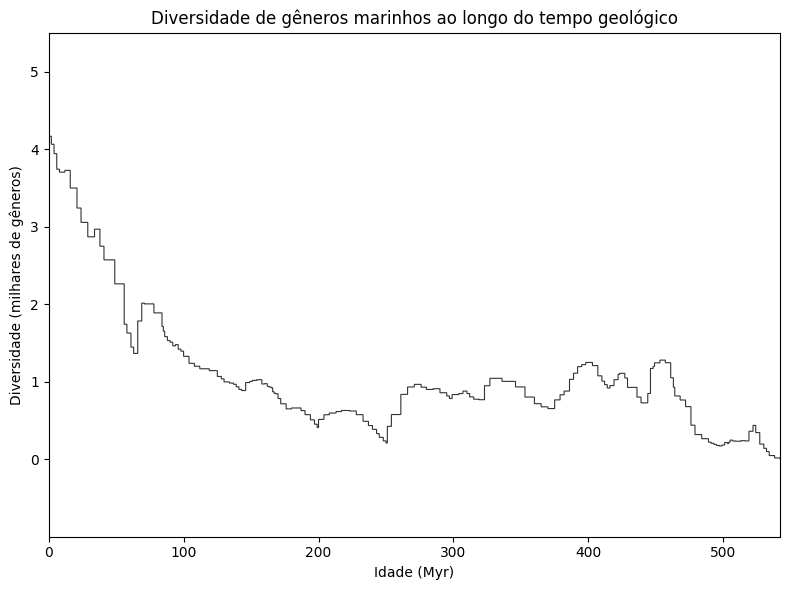

In [315]:
plotar_serie_temporal(x, y, 
                     "Diversidade de gêneros marinhos ao longo do tempo geológico",
                     "etapa1_diversidade_generos.png")

**Observações:**
- Tendência decrescente no longo prazo, e acentuada nos primeiros 80 Myr
- Picos notáveis: ~80, ~280-450, ~500 Myr
- Vales: ~100-250, ~450-500 Myr
- Possíveis padrões cíclicos superpostos à tendência

## Etapa 2 - Remoção da Tendência (Ajuste Polinomial)

Para isolar flutuações periódicas, ajustamos um polinômio de grau 3 removendo tendência de longo prazo.

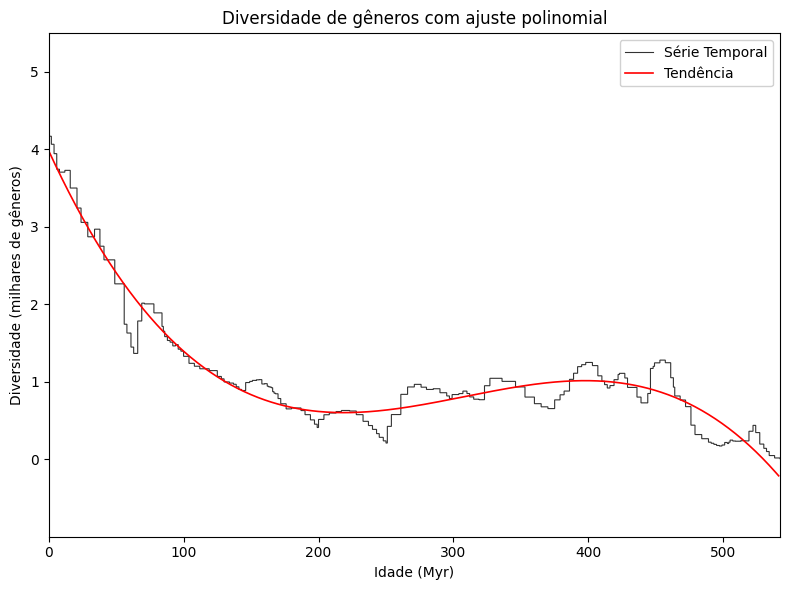

In [316]:
polinomio = ajustar_polinomio(y, grau=3)

plotar_serie_temporal(x, y,
                     "Diversidade de gêneros com ajuste polinomial",
                     "etapa2_remocao_tendencia.png",
                     polinomio=polinomio)

Subtraímos a tendência para obter resíduos apropriados para análise espectral.

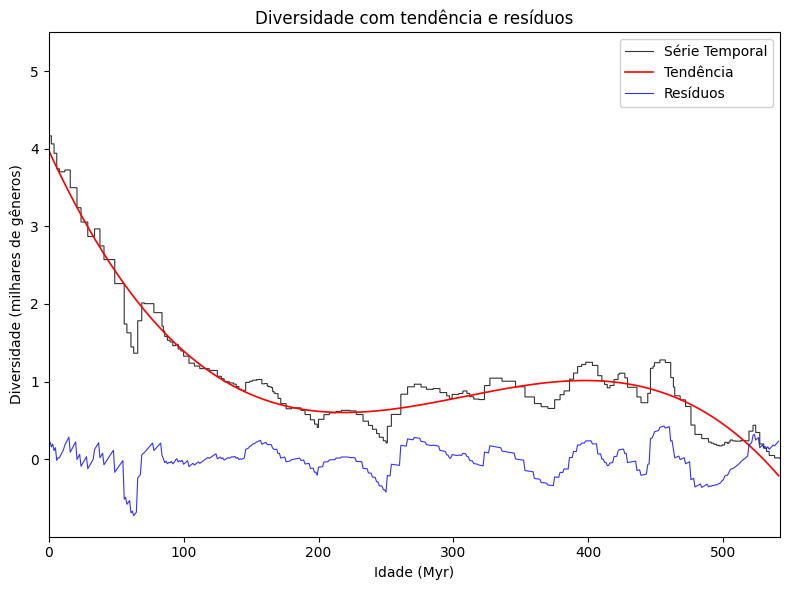

In [317]:
residuos = calcular_residuos(y, polinomio)

plotar_serie_temporal(x, y,
                     "Diversidade com tendência e resíduos",
                     "etapa2_residuos.png",
                     polinomio=polinomio,
                     residuos=residuos)

## Etapa 3 - Análise Espectral por FFT

Aplicamos FFT aos resíduos para decompor a série em diferentes frequências e identificar oscilações periódicas.

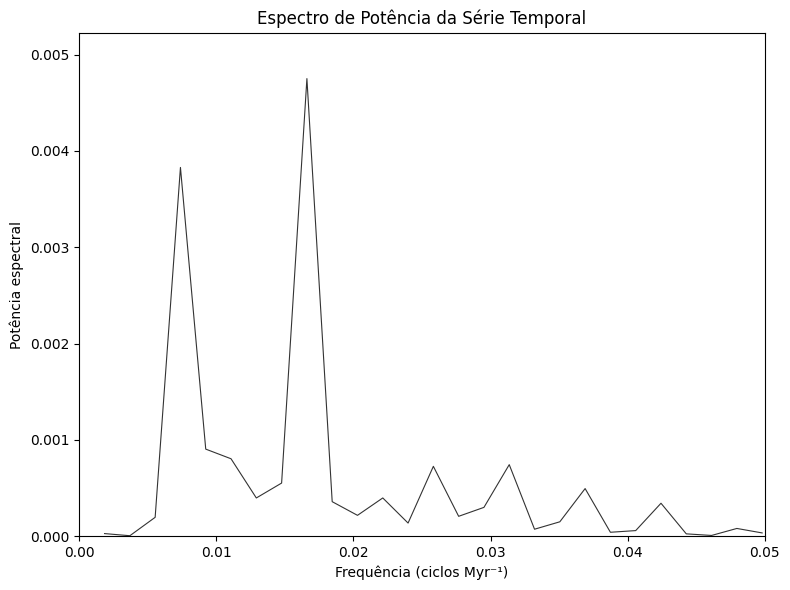

In [318]:
freqs, pots = calcular_espectro_potencia(residuos)

plotar_espectro_potencia(freqs, pots,
                        'Espectro de Potência da Série Temporal',
                        'etapa3_espectro_potencia.png')

Aplicamos zero padding para melhorar resolução espectral (como feito no artigo original, e discutido no material suplementar).

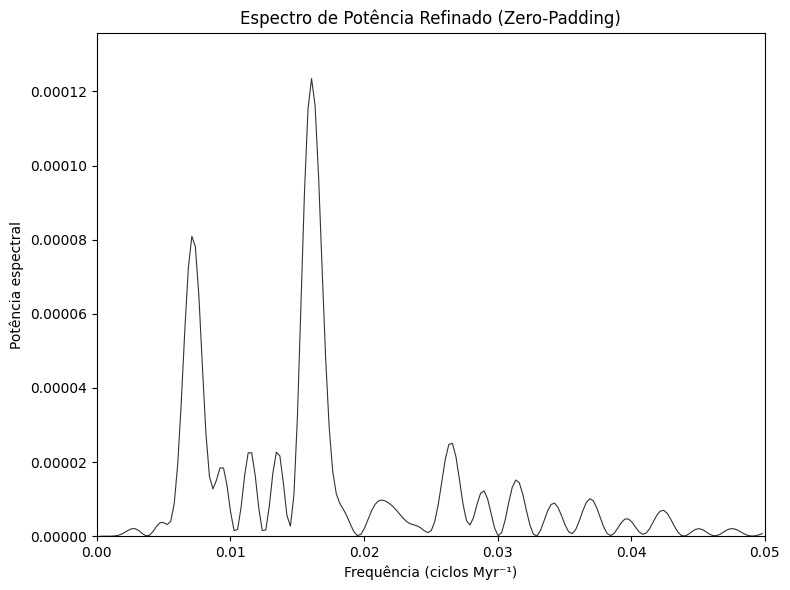

In [319]:
freqs_ref, pots_ref = calcular_espectro_potencia(residuos, pad=7)

plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência Refinado (Zero-Padding)',
                        'etapa3_espectro_potencia_refinado.png')

Procedemos à identificação de picos relevantes estabelecendo um threshold de 25% da potência máxima.

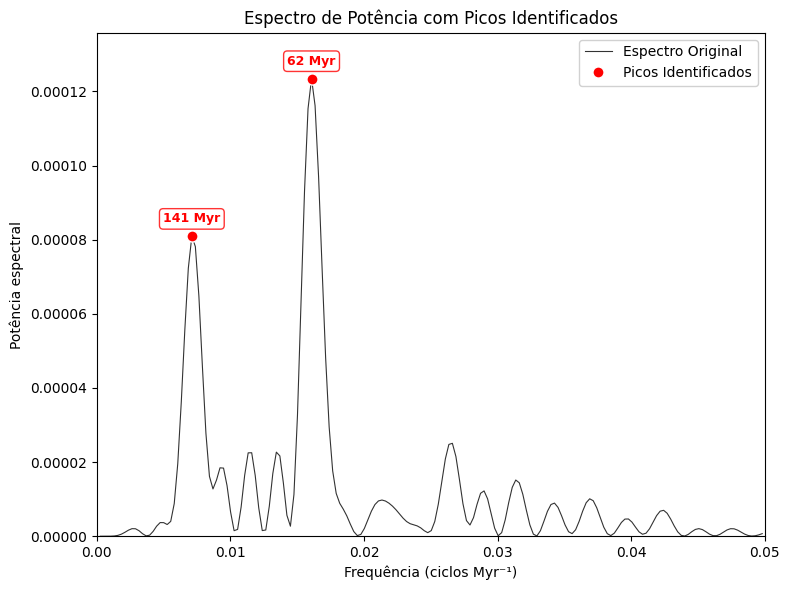

In [320]:
picos, propriedades = identificar_picos_espectrais(freqs_ref, pots_ref, threshold=0.25)

plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência com Picos Identificados',
                        'etapa3_espectro_potencia_picos_identificados.png',
                        picos=picos)

**Resultado:** Dois picos relevantes identificados em 62 e 141 Myr.

## Etapa 4 - Construção de Modelos Nulos (Monte Carlo)

Testamos significância dos picos com simulações que preservam características estatísticas dos dados originais.

**Estratégia:** Dois modelos complementares:
- **Modelo R:** Embaralhamento de incrementos (passeio aleatório)
- **Modelo W:** Embaralhamento de blocos (preserva autocorrelações locais)

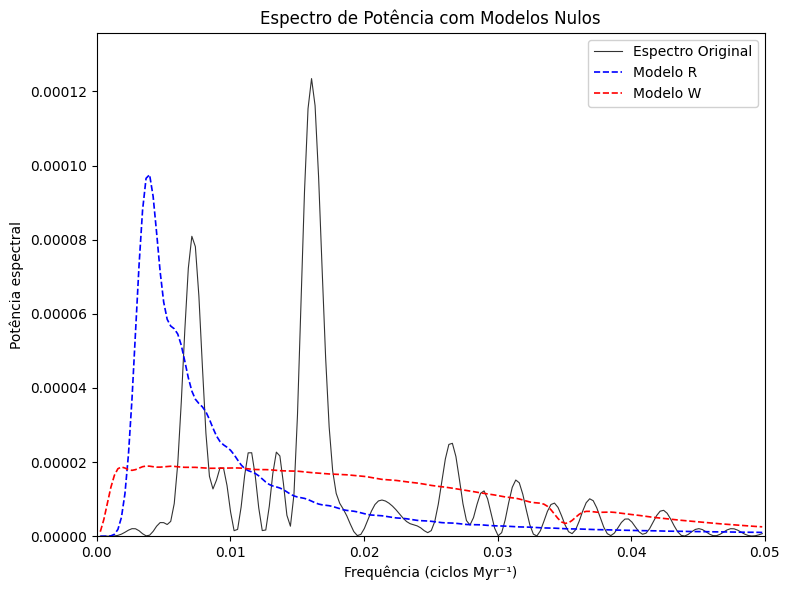

In [321]:
freqs_r, pots_r, individuais_r = modelo_r(y, grau=3, n_simulacoes=30000, pad=7, pots_ref=pots_ref)

freqs_w, pots_w, individuais_w = modelo_w(residuos, n_blocos=20, n_simulacoes=30000, pad=7, pots_ref=pots_ref)

plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência com Modelos Nulos',
                        'etapa4_espectro_potencia_modelos_nulos.png',
                        freqs_modelo1=freqs_r, pots_modelo1=pots_r, label_modelo1='Modelo R',
                        freqs_modelo2=freqs_w, pots_modelo2=pots_w, label_modelo2='Modelo W')

## Etapa 5 - Teste de Significância Estatística

Testamos significância estatística dos picos comparando-os com os modelos nulos.

In [322]:
results = gerar_tabela_significancia(freqs_ref, pots_ref, individuais_r, individuais_w)
results

,R (na freq.),W (na freq.),R (em qualquer freq.),W (em qualquer freq.)
62 Myr,0.000033,0.000133,0.788370,0.002331
140 Myr,0.124600,0.006567,0.866608,0.009027


## Etapa 6 - Discussão e Interpretação

Geramos um dashboard final integrando todos os resultados da análise espectral.

In [323]:
plotar_dashboard({
    'x': x, 'y': y, 'polinomio': polinomio, 'residuos': residuos,
    'freqs_ref': freqs_ref, 'pots_ref': pots_ref, 'picos': picos,
    'freqs_r': freqs_r, 'pots_r': pots_r,
    'freqs_w': freqs_w, 'pots_w': pots_w
})

### Discussão

A análise espectral confirmou a presença de um ciclo estatisticamente significativo com período de aproximadamente 62 milhões de anos na diversidade de fósseis marinhos ao longo do Fanerozoico. Esse sinal se destaca tanto visualmente no espectro quanto pelos testes estatísticos de Monte Carlo aplicados a dois modelos nulos distintos, com p-valores baixos mesmo após correção para múltiplas comparações.

O segundo pico identificado, em torno de 140 Myr, embora presente no espectro de potência, não demonstrou significância estatística robusta frente aos modelos nulos utilizados, especialmente sob o teste global. Isso sugere que sua ocorrência pode estar associada ao ruído inerente à estrutura temporal da série. Uma interpretação mais detalhada será apresentada no relatório.